# Song Embedding

In [1]:
from pyspark.sql import SparkSession
from pylab import plot, show
import matplotlib.pyplot as plt
import numpy as np
import json

spark = SparkSession.builder.appName('song_vocab').getOrCreate()

### Using GloVe (https://nlp.stanford.edu/projects/glove/), we turn each song into an embedding based on its lyrics and song-vectors.txt contain these embeddings.

In [2]:
vectors_file = 'song-vectors.txt' # each line contain a songID, then its embedding vector

with open(vectors_file, 'r') as f:
    songs = []
    song_vectors = {}
    song_matrix = []
    for line in f:
        vals = line.rstrip().split(' ')
        word, vector = vals[0], [float(x) for x in vals[1:]]
        songs.append(word)
        song_vectors[word] = vector
        song_matrix.append(vector)
song_matrix = np.array(song_matrix)
song_vocab  = {w: idx for idx, w in enumerate(songs)}
song_ivocab = {idx: w for idx, w in enumerate(songs)}

### k-means++ clustering the songs based on embedding vectors

In [10]:
# songs # Song IDs
# song_vectors # Dict key = ID : Value = Embedding Vectors
# song_matrix # ith row is ith embedding vector in same order of songs
# song_vocab # Dict key = ID : Value = Index in songs/song_matrix

from pyspark.mllib.clustering import KMeans, KMeansModel

song_data = spark.sparkContext.parallelize(song_matrix)
model = KMeans.train(song_data, 5, maxIterations=100, initializationMode="random")
labels = model.predict(song_data).collect()
# labels is the cluster assignment from k-means, indexed in the same order as songs

In [8]:
songs_to_tags_file = '/playlist/song-to-tags.txt' # song to tag (genre) hashes
taghash_to_tags_file = '/playlist/tag_hash.txt' # tag hash to tags (genre names)
songID_to_name_file = '/playlist/song_hash.txt' # songID to song

with open(songs_to_tags_file, 'r') as f:
    song_to_tags = [] # matrix
    for line in f:
        vals = line.rstrip().split('\t')
        songID = vals[0]
        tags = vals[1].split(',')
        if (tags[0] != '#') and (songID in song_vocab):
            song_to_tags.append([songID, tags])
with open(taghash_to_tags_file, 'r') as f:
    taghash_to_tags = {} # dict
    for line in f:
        vals = line.rstrip().split(', ')
        taghash, name = vals[0], vals[1]
        taghash_to_tags[taghash] = name
with open(songID_to_name_file, 'r') as f:
    songID_to_name = {} # dict
    for line in f:
        vals = line.rstrip().split('\t')
        id, song_name, artist = vals[0], vals[1], vals[2]
        songID_to_name[id] = (song_name,artist)

In [11]:
# I can turn [song_id, [tags]] => (cluster_assignment, [tags])
# song_vocab[x[0]] gives index of song, then we find its cluster assignment
# Then, reduceByKey on the cluster_assignment
# Lastly, I put a Counter to get the number of occurrence of each tag
from collections import Counter

song_tags_data = spark.sparkContext.parallelize(song_to_tags) \
                      .map(lambda x: (labels[int(song_vocab[x[0]])], x[1])) \
                      .reduceByKey(lambda x,y: x + y) \
                      .map(lambda x: (x[0], Counter(x[1]).most_common(5))).collect()
def hash_to_tag(x):
    arr = [(taghash_to_tags[y[0]],y[1]) for y in x[1]]
    return (x[0], arr)

song_tags_data = map(hash_to_tag,song_tags_data)

for i in range(0,len(song_tags_data)):
    print song_tags_data[i]

(0, [('pop', 114), ('dance', 97), ('hip-hop', 91), ('rnb', 88), ('hip hop', 81)])
(1, [('country', 336), ('my favorite', 217), ('classic country', 201), ('great song', 195), ('beautiful', 159)])
(2, [('rock', 2539), ('pop', 2397), ('favorites', 2229), ('male vocalists', 1791), ('love', 1685)])
(3, [('rock', 554), ('favorites', 493), ('pop', 446), ('male vocalists', 392), ('american', 382)])
(4, [('pop', 416), ('favorites', 354), ('rock', 350), ('love', 349), ('male vocalists', 254)])


The above results has cluster 3 with songs primarily from the rock and alternative genre. Cluster 4 has pop music and favorite love songs. Cluster 0 contains dance, hip-hop (hip hop), and R&B music. Cluster 2 is a huge cluster with most pop songs. Lastly, cluster 1 features country music.

The clustering seems to make intuitive sense because the most common genres within each cluster are very much related. For example, cluster 0's rock genre overlaps heavily with alternative and pop music and usually feature male vocalists, which is reflected in the result. Moreover, there are two distinct clusters (hip-hop/R&B - 2, country music - 4); each of which features music that are relatively distinct from other forms of music. Therefore, the clustering makes intuitive sense.

### Apply t-Distributed Stochastic Neighbor Embedding (t-SNE) to represent the song embedding vectors in two dimensions 

In [12]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib notebook

In [17]:
tsne_song = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
Y2 = tsne_song.fit_transform(song_matrix[:1500,:])

<IPython.core.display.Javascript object>


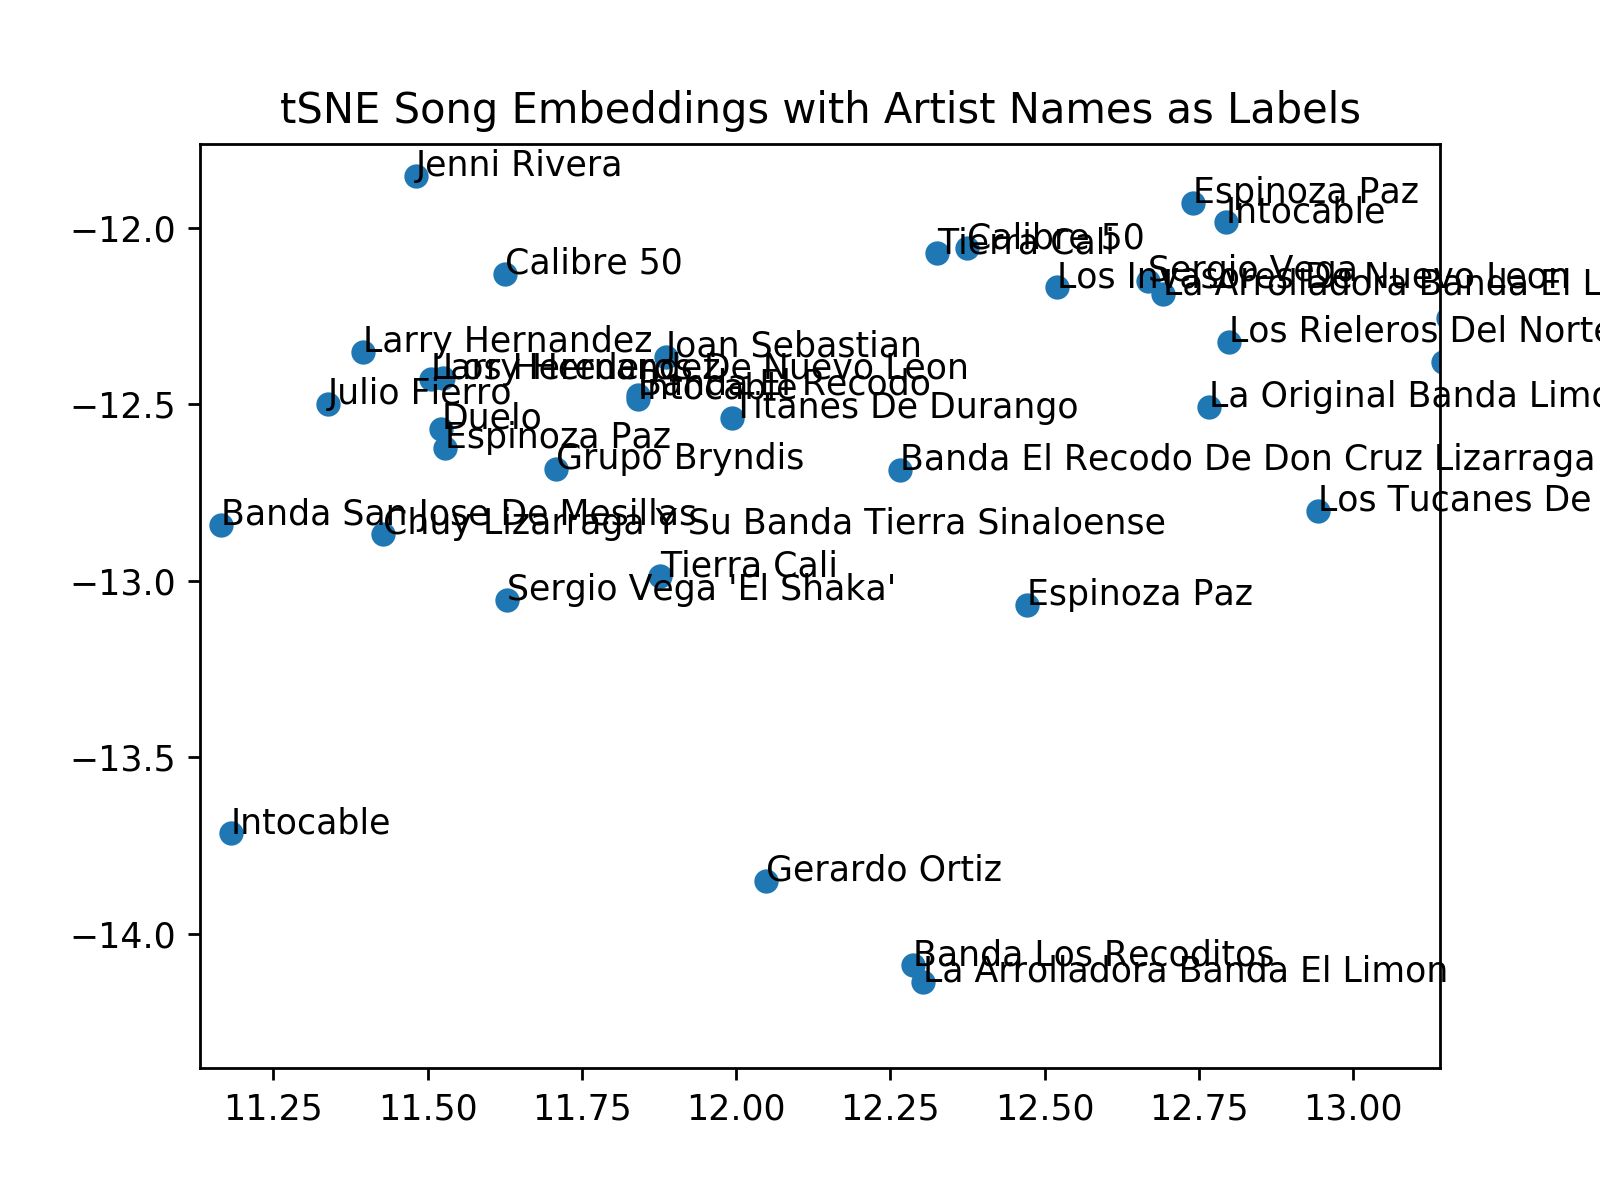

In [31]:
plt.scatter(Y2[:, 0], Y2[:, 1])
for song, x, y in zip(songs, Y2[:, 0], Y2[:, 1]):
    plt.annotate(songID_to_name[song][1], xy=(x, y), xytext=(0, 0), textcoords='offset points')
plt.title("tSNE Song Embeddings with Artist Names as Labels")
plt.show()

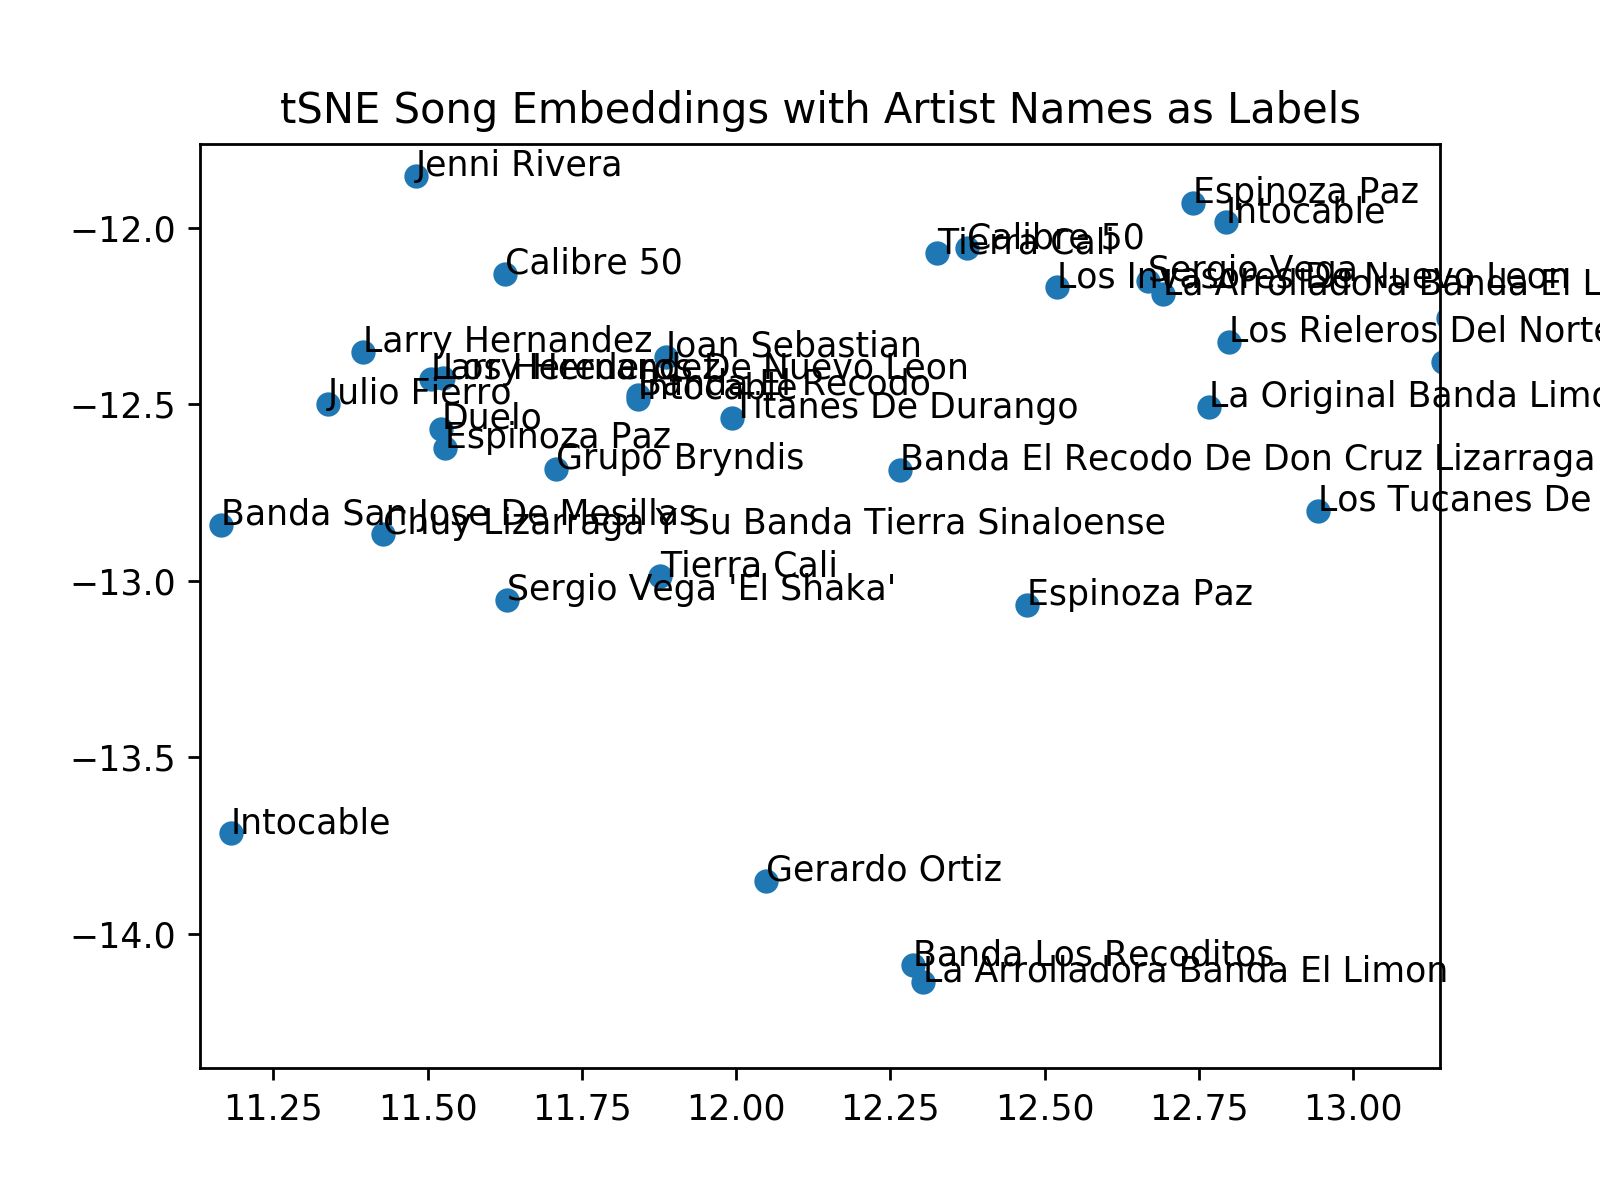

In [32]:
from IPython.display import Image
Image(filename='song_embedding.png', width=600, height=600)

We choose to label each song with its artist name to see if songs by the same artist are likely cluster together, and from the artists' names, we can easily tell how music in the same playlist relate to each other. If we opted for song title instead, it could have been difficult to tell the genre of the song. The area that we landed on contains songs all from the Latin music genre. In particular, we see a few artists' names repeated pop up (e.g. Calibre 50, Espinoza Paz). This demonstrates that songs by the same artist are likely to appear in the same playlist. In addition, since the area above only contain Latin music, we see that songs within a playlist often contain the same genre and in this case, specifically language as well. One possible explanation is that Spanish speakers will likely to have multiple Spanish songs in their playlists, whereas non-Spanish speakers are likely to have zero. This distinction can cause Latin music to be in a different area from other songs.

## Artist Embedding
### This time we are interested in how artists are related to each other based on a dataset of playlists and see how frequently certain artists are grouped together. Again, GloVe was applied onto the dataset to get an embedding vector of each artist.

In [22]:
artist_vector_file = 'artist-vectors.txt'

with open(artist_vector_file, 'r') as f:
    artists = []
    artist_vectors = {} # dict, from artistID to its embedding vector
    artist_matrix = [] # a matrix of all embedding vector
    for line in f:
        vals = line.rstrip().split(' ')
        artist, vector = vals[0], [float(x) for x in vals[1:]]
        artists.append(artist)
        artist_vectors[artist] = vector
        artist_matrix.append(vector)
artist_matrix = np.array(artist_matrix)
artist_vocab  = {w: idx for idx, w in enumerate(artists)} # artist to initial index position 
artist_ivocab = {idx: w for idx, w in enumerate(artists)} # initial index position to artist

### Finding the most closest related artists of a given artist (e.g. The Beatles, Usher, RHCP).

In [23]:
artist_file = '/playlist/artist-playlists.txt' # artistID to tag hashes
artist_hash_file = '/playlist/artist_hash.txt' # artistID to artist

with open(artist_file, 'r') as f:
    artist_tags = [] # matrix
    for line in f:
        vals = line.rstrip().split(' ')
        if (len(vals) > 1):
            id = vals[0]
            tags = vals[1:]
            artist_tags.append([id, tags])
# [[id,tags],...,[]]    

with open(artist_hash_file, 'r') as f:
    ID_to_artist = {} # dict
    artist_to_ID = {}
    for line in f:
        vals = line.rstrip().split('\t')
        id, name = vals[0], vals[1]
        ID_to_artist[id] = name
        artist_to_ID[name] = id
        
# artist_to_ID['The Beatles'] # id = 2495
# artist_to_ID['Usher'] # id = 353
# artist_to_ID['The Red Hot Chili Peppers'] # id = 229

In [19]:
# artist_tags_data = spark.sparkContext.parallelize(artist_tags) \
#                         .map(lambda x: (ID_to_artist[x[0]], x[1])) \
#                         .reduceByKey(lambda x,y: x + y) \
#                         .map(lambda x: (x[0], Counter(x[1]))).collect()

# given n-dim vector v and matrix with vectors in rows,
# returns the indices of the k closest vectors to v
def nearest_vectors_ind(v, emb_matrix, k):
    assert k >= 1
    distances = np.linalg.norm(v - emb_matrix, axis=1)
    if k == 1:
        return np.argmin(distances)
    else:
        return np.argsort(distances)[:k]


# given a word and embedding information, finds the k nearest
# words; returns a list
def nearest_words(w, emb_ivocab, emb_vectors, emb_matrix, k):
    v = np.array(emb_vectors[w])
    ind = nearest_vectors_ind(v, emb_matrix, k+1)
    return [ID_to_artist[emb_ivocab[i]] for i in ind[1:]]

beatles_5closest = nearest_words(artist_to_ID['The Beatles'],artist_ivocab, artist_vectors, artist_matrix, 5);
usher_5closest = nearest_words(artist_to_ID['Usher'],artist_ivocab, artist_vectors, artist_matrix, 5);
RHCP_5closest = nearest_words(artist_to_ID['The Red Hot Chili Peppers'],artist_ivocab, artist_vectors, artist_matrix, 5);

print "The 5 closest artists to The Beatles are:"
print beatles_5closest
print "The 5 closest artists to Usher are:"
print usher_5closest
print "The 5 closest artists to The Red Hot Chili Peppers are:"
print RHCP_5closest

The 5 closest artists to The Beatles are:
['Creedence Clearwater Revival', 'The Kinks', 'The Electric Light Orchestra', 'America', 'Bachman-Turner Overdrive']
The 5 closest artists to Usher are:
['B.o.B', 'Far East Movement', 'Flo-Rida', 'B.o.B.', 'Jay Sean']
The 5 closest artists to The Red Hot Chili Peppers are:
['Stone Temple Pilots', 'Pearl Jam', 'Nirvana', 'Sublime', 'Bush']


The above results of closest artist based on embedding vectors make intuitive sense, because the time period and genre of each related artist is very similar to that of the given artist. The Beatles's closest artists are all rock bands from the late 1960s to 1970s, primarily originated from English. The closest artists to Usher are all Hip-hop and R&B artists in the 2000s like Usher himself. For The Red Hot Chili Peppers, the closest artists are grunge, alternative rock bands primarily from West Coast of the U.S., exactly like the band itself. Listeners to any of the given artists are likely to listen artists in time period and genre. Therefore, it makes sense that the closest related artists are in the same time period and genre as the results have shown.

### Apply t-SNE and plot

In [24]:
tsne_artist = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
Y = tsne_artist.fit_transform(artist_matrix[:3000,:])

<IPython.core.display.Javascript object>


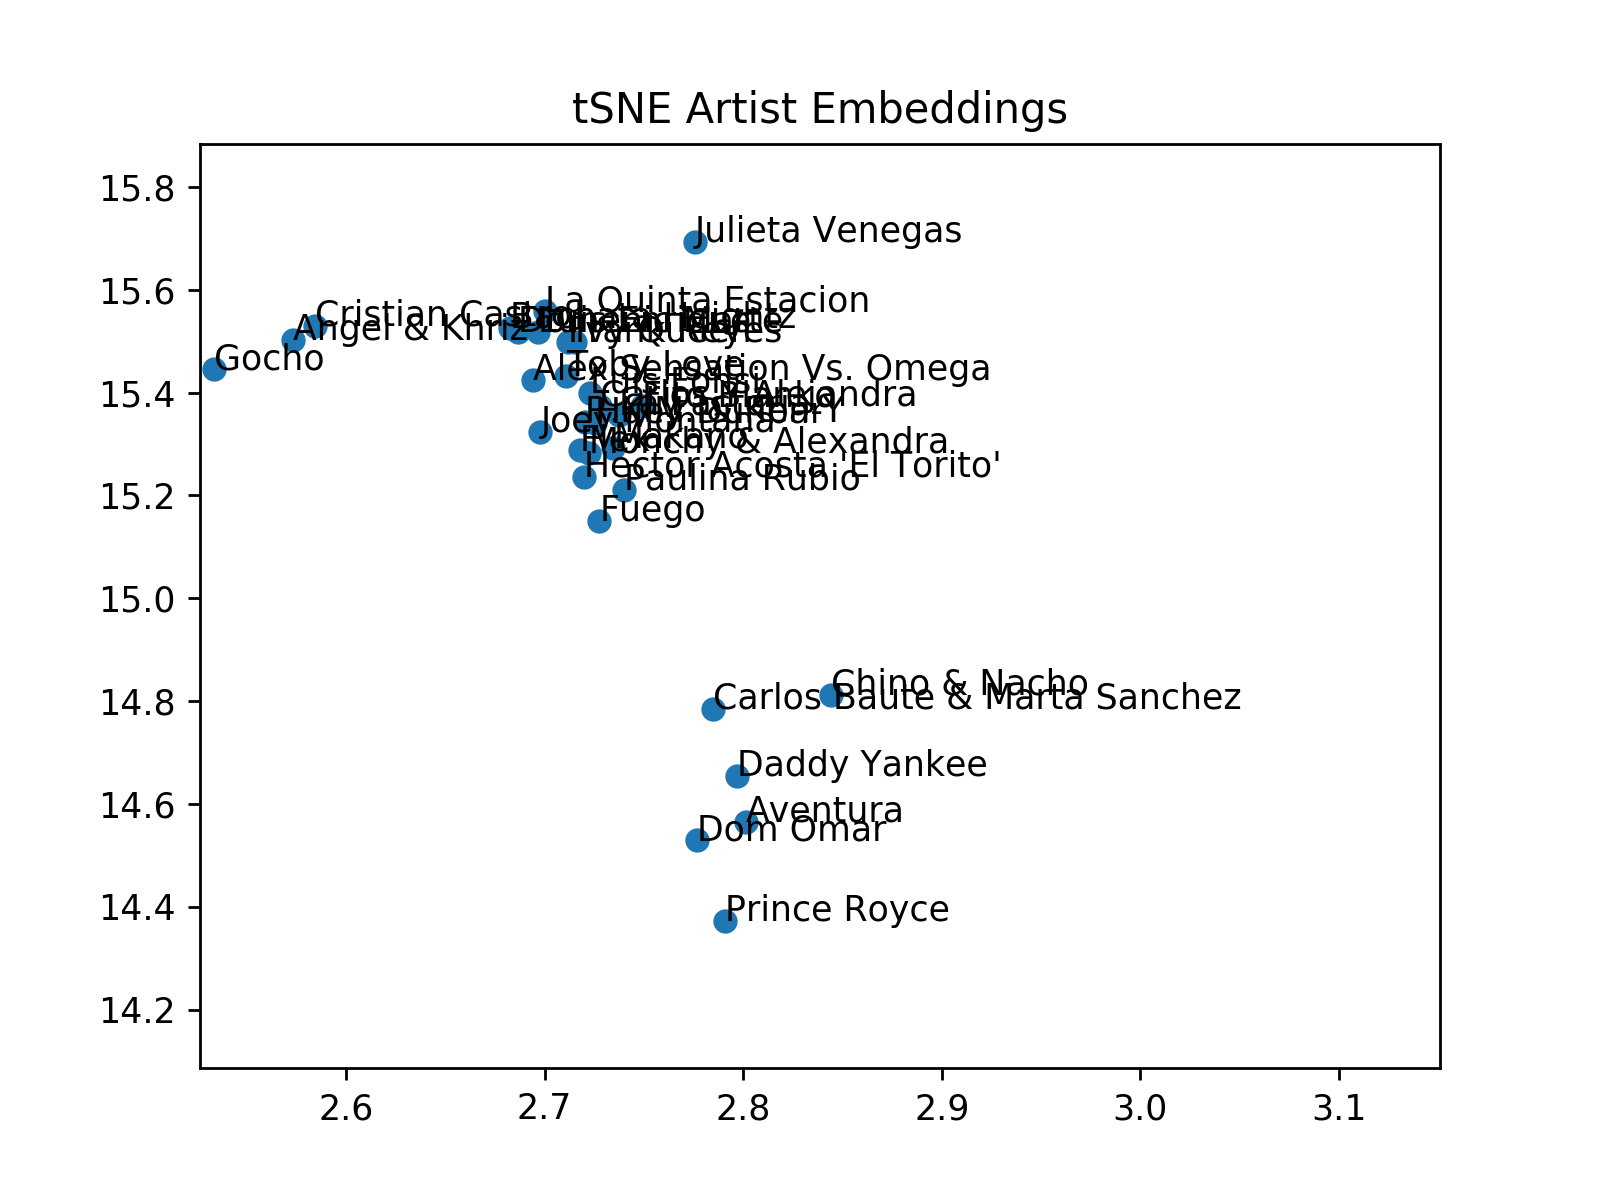

In [26]:
plt.scatter(Y[:, 0], Y[:, 1])
for artist, x, y in zip(artists, Y[:, 0], Y[:, 1]):
    plt.annotate(ID_to_artist[artist], xy=(x, y), xytext=(0, 0), textcoords='offset points')
plt.title("tSNE Artist Embeddings")
plt.show()

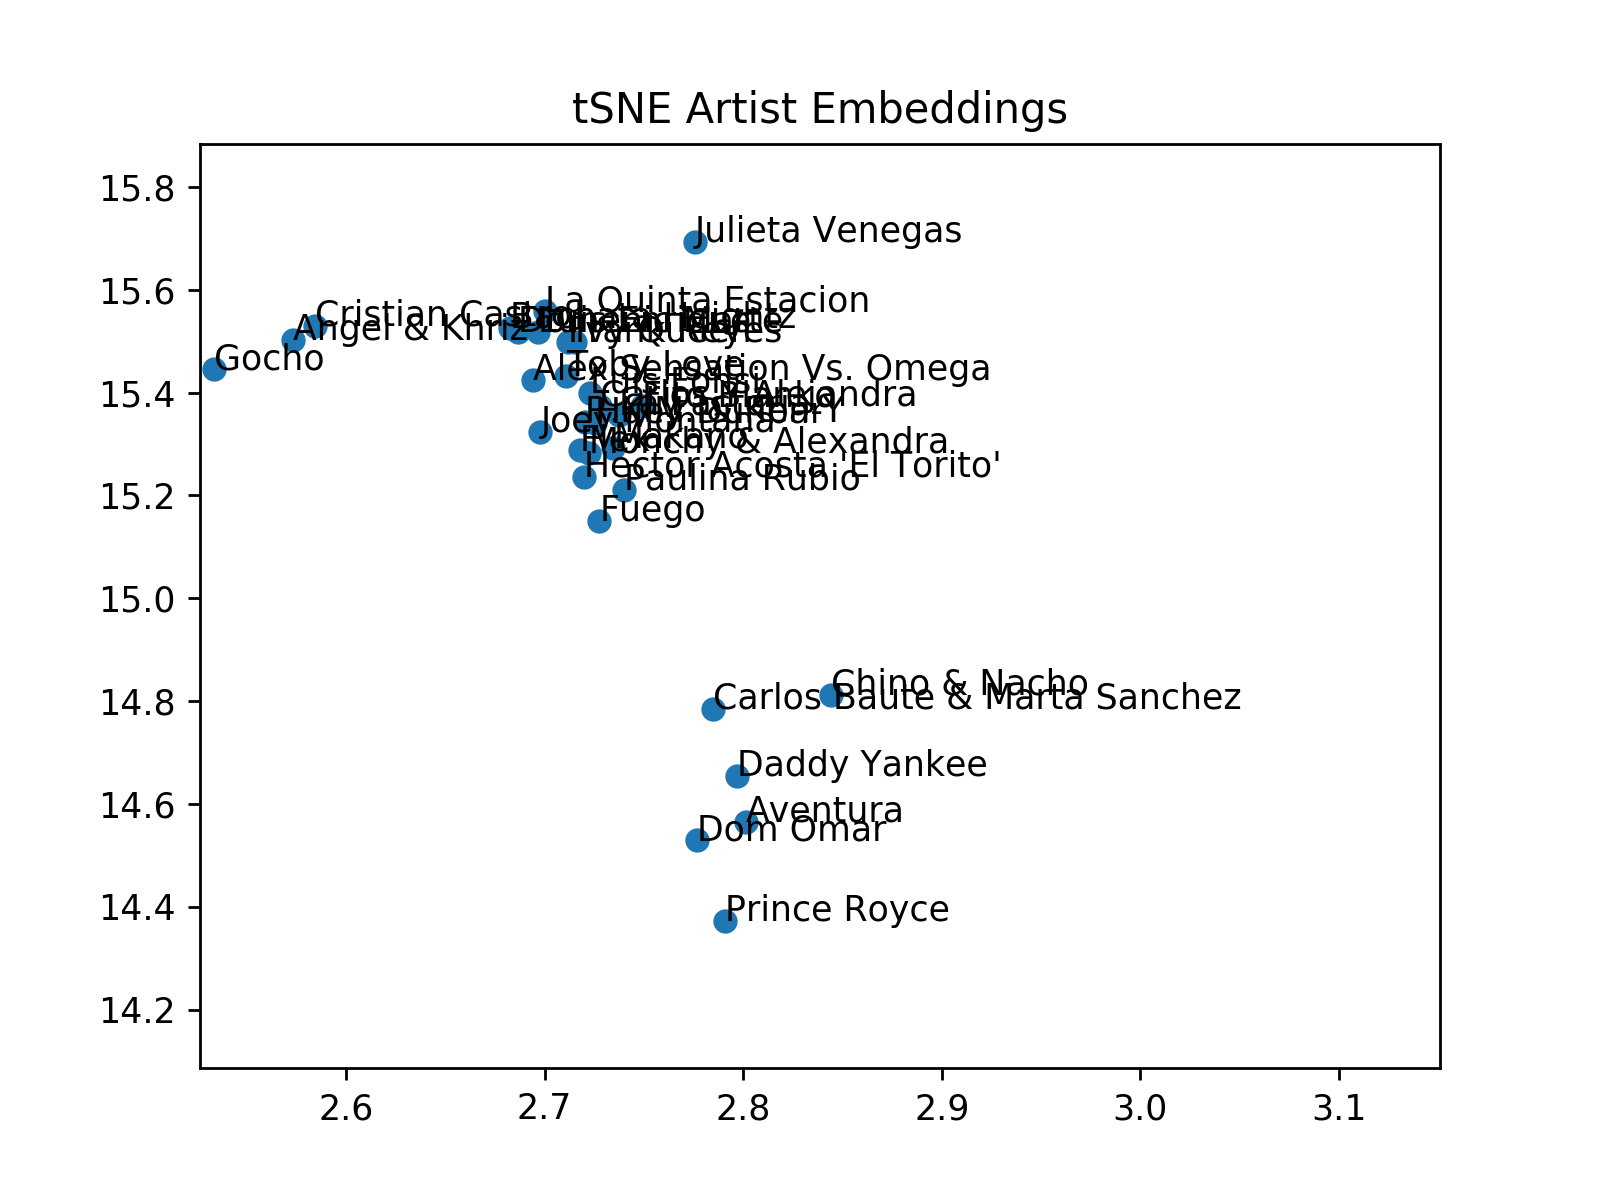

In [30]:
Image(filename='artist_embedding.png', width=600, height=600)

Similar to the song embedding, we again have an area where all artists belong in the Latin music genre. As we have mentioned before, artists of the same genre (and in this case specifically language) are likely to be in the same music playlist. Latin music has its own area isolated from the music possibly because most non-Spanish speakers do not listen to Latin music. An interesting observation about the area above is that the bottom cluster consists of all Latin hip-hop artists, whereas the top cluster consists of more female artists. We see that even within an area of the plot that represents a genre/language, the artists cluster into smaller subgenres within the area. This gives validity to the usage of embedding and the subsequent dimensionality reduction, and the result makes sense.